In [156]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguedashlineups
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashlineups
from nba_api.stats.endpoints import leaguegamelog
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import time

In [57]:
def LineupData(season,per):
    tempdf1 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Advanced',
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Four Factors', 
                                                  season = season,
                                                  per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Misc',
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Scoring', 
                                                  season = season, 
                                                  per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Opponent',
                                                  season = season,
                                                  per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    
    tempdf = pd.merge(tempdf1,tempdf2, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on= 'GROUP_ID', how='outer',suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    tempdf1 = tempdf[['GROUP_ID','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [92]:
def LineupData1(season,per):
    tempdf = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf1 = tempdf[['GROUP_ID','GP','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [93]:
def PlayerData(season,per):
    tempdf1 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Advanced', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Usage', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Misc', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Scoring', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Defense', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf = pd.merge(tempdf1,tempdf2, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    print('done')
    return(tempdf)

In [94]:
#Returns dictionary of scores
def nMax(n,playerids,attributes):
    teamscore = 0
    #Loop through players in lineup
    teamAttr = defaultdict(list)
    for player in playerids:
        playerstats = dfPlayer.loc[dfPlayer['PLAYER_ID'] == int(player)]
            
        for attr in attributes:
            playerscore = playerstats.iloc[0][attr]
            teamAttr[attr].append(playerscore)

    rawAttr = defaultdict()
    for x in teamAttr:
        teamAttr[x].sort(reverse = True)
        teamAttr[x] = teamAttr[x][:n]
        rawAttr[x] = sum(teamAttr[x][:n])
    return(rawAttr)

In [95]:
def Train(df,attributes):
    for index, row in df.iterrows():
        playerids = row['GROUP_ID'].split("-")[1:-1]
        
        info = nMax(2,playerids,attributes)

        for key,value in info.items():
            df.at[index,key] = value
            
    return(df)

In [148]:
def ScoreCalc(df,attributes):
    df1 = Train(df,attributes)
    df1 = df1.loc[(df1['GP'] >= 10)]
    
    coeff = {}
    for attr in attributes:
        model = sm.OLS(df1['PLUS_MINUS'],df1[attr]).fit()
        val = model.tvalues[0] 
        coeff[attr] = val
    
    #calculate the scores
    df1['Score'] = (coeff[attributes[0]]*df1[attributes[0]] + coeff[attributes[1]]*df1[attributes[1]] + 
        coeff[attributes[2]]*df1[attributes[2]] + coeff[attributes[3]]*df1[attributes[3]] + 
        coeff[attributes[4]]*df1[attributes[4]] + coeff[attributes[5]]*df1[attributes[5]] + 
        coeff[attributes[6]]*df1[attributes[6]] + coeff[attributes[7]]*df1[attributes[7]])
    
#     df1['score'] = df1.apply(lambda x: coeff[attributes[0]]*df1[attributes[0]] + coeff[attributes[1]]*df1[attributes[1]] + 
#         coeff[attributes[2]]*df1[attributes[2]] + coeff[attributes[3]]*df1[attributes[3]] + 
#         coeff[attributes[4]]*df1[attributes[4]], axis=1)
    
    return(df1)
        

In [143]:
dfLineup = LineupData1('2017-18','Per100Possessions')
dfPlayer = PlayerData('2017-18','Per100Possessions')
print(len(dfLineup))
print(len(dfPlayer))
print(list(dfPlayer.columns))

done
done
2000
540
['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'AGE', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'BLKA', 'PF', 'PFD', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3', 'CFID', 'CFPARAMS', 'eOFF_RATING', 'OFF_RATING', 'sp_work_OFF_RATING', 'eDEF_RATING', 'DEF_RATING', 'sp_work_DEF_RATING', 'eNET_RATING', 'NET_RATING', 'sp_work_NET_RATING', 'AST_PCT', 'AST_TO', 'AST_RATIO', 'OREB_PCT', 'DREB_PCT', 'REB_PCT', 'TM_TOV_PCT', 'EFG_PCT', 'TS_PCT', 'USG_PCT', 'ePACE', 'PACE', 'sp_work_PACE', 'PIE', 'FGM_PG', 'FGA_PG', 'PCT_FGM', 'PCT_FGA', 'PCT_FG3M', 'PCT_FG3A', 'PCT_FTM', 'PCT_FTA', 'PCT_OREB', 'PCT_DREB', 'PCT_REB', 'PCT_AST', 'PCT_TOV', 'PCT_STL', 'PCT_BLK', 'PCT_BLKA', 'PCT_PF', 'PCT_PFD', 'PCT_PTS', 'PTS_OFF_TOV', 'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT', 'OPP_PTS_OFF_TOV', 'OPP_PTS_2ND_CHANCE', 'OPP_PTS_FB', 'OPP_PTS_PAINT', 'PCT_FGA_2PT'

In [188]:
attributes = ['AST','OREB','DREB','BLK','FGM','FG3M','STL','PIE']
rand = nMax(2,playerids,attributes)
print(rand)
print(type(rand))

defaultdict(None, {'AST': 12.8, 'OREB': 5.1, 'DREB': 17.2, 'BLK': 3.5, 'FGM': 17.5, 'FG3M': 5.5, 'STL': 3.1, 'PIE': 0.249})
<class 'collections.defaultdict'>


In [153]:
tem = ScoreCalc(dfLineup,attributes)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [154]:
tem.head()
model = sm.OLS(tem['PLUS_MINUS'],tem['score']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PLUS_MINUS   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     11.55
Date:                Thu, 21 Feb 2019   Prob (F-statistic):           0.000715
Time:                        02:23:16   Log-Likelihood:                -3182.3
No. Observations:                 717   AIC:                             6367.
Df Residuals:                     716   BIC:                             6371.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          0.0104      0.003      3.398      0.001       0.004       0.016
==============================================================================
Omnibus:                       17.479   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.891
Skew:                          -0.051   Prob(JB):                     2.65e-08
Kurtosis:                       4.076   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
rand1.head()
rand1 = rand1.loc[(rand1['GP'] >= 10)]

#model = sm.OLS(dfLineup['PLUS_MINUS'],xvar).fit()
rand2 = rand1.iloc[:,3:]
model = sm.OLS(rand1['PLUS_MINUS'],rand1['OREB']).fit()

print(model.params.values[0])
print(model.tvalues[0])
dir(model)
print(type(model.params))
#model = sm.OLS(dfLineup['PLUS_MINUS'],dfLineup['PIE']).fit()
#predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

0.30394681872800805
2.6656532345404385
<class 'pandas.core.series.Series'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PLUS_MINUS   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.106
Date:                Thu, 21 Feb 2019   Prob (F-statistic):            0.00786
Time:                        02:05:13   Log-Likelihood:                -3184.5
No. Observations:                 717   AIC:                             6371.
Df Residuals:                     716   BIC:                             6376.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
OREB           0.3039      0.114      2.666      0.008       0.080       0.528
==============================================================================
Omnibus:                       17.096   Durbin-Watson:                   1.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.813
Skew:                          -0.048   Prob(JB):                     4.55e-08
Kurtosis:                       4.060   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
games = leaguegamelog.LeagueGameLog().get_data_frames()[0]
print(list(games.columns))
print(len(games))
games.head()

['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE']
1732


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22018,1610612744,GSW,Golden State Warriors,0021800002,2018-10-16,GSW vs. OKC,W,240,42,...,41,58,28,7,7,21,29,108,8,1
1,22018,1610612760,OKC,Oklahoma City Thunder,0021800002,2018-10-16,OKC @ GSW,L,240,33,...,29,45,21,12,6,15,21,100,-8,1
2,22018,1610612738,BOS,Boston Celtics,0021800001,2018-10-16,BOS vs. PHI,W,240,42,...,43,55,21,7,5,15,20,105,18,1
3,22018,1610612755,PHI,Philadelphia 76ers,0021800001,2018-10-16,PHI @ BOS,L,240,34,...,41,47,18,8,5,16,20,87,-18,1
4,22018,1610612750,MIN,Minnesota Timberwolves,0021800010,2018-10-17,MIN @ SAS,L,240,39,...,32,46,20,9,2,11,27,108,-4,2


In [171]:
from nba_api.stats.endpoints import commonteamroster
roster = commonteamroster.CommonTeamRoster(1610612760).get_data_frames()[0]

roster.head(20)

,TeamID,SEASON,LeagueID,PLAYER,NUM,POSITION,HEIGHT,WEIGHT,BIRTH_DATE,AGE,EXP,SCHOOL,PLAYER_ID
0,1610612760,2018,00,Markieff Morris,None,F,6-10,245,"SEP 02, 1989",29.0,7,Kansas,202693
1,1610612760,2018,00,Russell Westbrook,0,G,6-3,200,"NOV 12, 1988",30.0,10,UCLA,201566
2,1610612760,2018,00,Raymond Felton,2,G,6-1,205,"JUN 26, 1984",34.0,13,North Carolina,101109
3,1610612760,2018,00,Nerlens Noel,3,F-C,6-11,220,"APR 10, 1994",24.0,4,Kentucky,203457
4,1610612760,2018,00,Richard Solomon,5,F,6-11,240,"JUN 18, 1992",26.0,R,California,204076
5,1610612760,2018,00,Hamidou Diallo,6,G,6-5,198,"JUL 31, 1998",20.0,R,Kentucky,1628977
6,1610612760,2018,00,Jerami Grant,9,F,6-9,220,"MAR 12, 1994",24.0,4,Syracuse,203924
7,1610612760,2018,00,Abdel Nader,11,F,6-6,225,"SEP 25, 1993",25.0,1,Iowa State,1627846
8,1610612760,2018,00,Steven Adams,12,C,7-0,265,"JUL 20, 1993",25.0,5,Pittsburgh,203500
9,1610612760,2018,00,Paul George,13,F,6-9,220,"MAY 02, 1990",28.0,8,Fresno State,202331


In [187]:
nba_teams = teams.get_teams()

teamLineups = defaultdict(str)
for team in nba_teams:
    teamid = team['id']
    teamdf = teamdashlineups.TeamDashLineups(teamid, season = '2017-18',per_mode_detailed = 'Totals').get_data_frames()[1]
    #print(teamdf.head())
    teamdf.sort_values('MIN',ascending = True)
    teamLineups[team['abbreviation']] = teamdf.iat[0,1].split("-")[1:-1]
    print("done")
    print(teamLineups)
    time.sleep(2)

done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752']})
done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752'], 'BOS': ['201143', '202681', '203382', '1627759', '1628369']})
done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752'], 'BOS': ['201143', '202681', '203382', '1627759', '1628369'], 'CLE': ['2544', '2747', '101181', '201567', '203109']})
done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752'], 'BOS': ['201143', '202681', '203382', '1627759', '1628369'], 'CLE': ['2544', '2747', '101181', '201567', '203109'], 'NOP': ['200765', '201950', '202326', '202734', '203076']})
done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752'], 'BOS': ['201143', '202681', '203382', '1627759', '1628369'], 'CLE': ['2544', '2747', '101181', '201567', '203109'], 'NOP': ['200765', '201950', '202326', '202734', '203076'], 'CHI

done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752'], 'BOS': ['201143', '202681', '203382', '1627759', '1628369'], 'CLE': ['2544', '2747', '101181', '201567', '203109'], 'NOP': ['200765', '201950', '202326', '202734', '203076'], 'CHI': ['201577', '203200', '1627739', '1627756', '1628374'], 'DAL': ['1717', '202083', '203084', '1628372', '1628467'], 'DEN': ['200794', '201163', '203914', '203999', '1627750'], 'GSW': ['2585', '201142', '201939', '202691', '203110'], 'HOU': ['2772', '101108', '200782', '201935', '203991'], 'LAC': ['101150', '201599', '202699', '203085', '1628414'], 'LAL': ['201572', '203484', '1627742', '1628366', '1628398'], 'MIA': ['201609', '201949', '202355', '204020', '1626196'], 'MIL': ['202339', '203089', '203114', '203503', '203507'], 'MIN': ['201952', '201959', '202710', '203952', '1626157'], 'BKN': ['201960', '203092', '203459', '203915', '1626178'], 'NYK': ['101127', '201584', '202683', '203501', '204001'], 'ORL': ['202687',

done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752'], 'BOS': ['201143', '202681', '203382', '1627759', '1628369'], 'CLE': ['2544', '2747', '101181', '201567', '203109'], 'NOP': ['200765', '201950', '202326', '202734', '203076'], 'CHI': ['201577', '203200', '1627739', '1627756', '1628374'], 'DAL': ['1717', '202083', '203084', '1628372', '1628467'], 'DEN': ['200794', '201163', '203914', '203999', '1627750'], 'GSW': ['2585', '201142', '201939', '202691', '203110'], 'HOU': ['2772', '101108', '200782', '201935', '203991'], 'LAC': ['101150', '201599', '202699', '203085', '1628414'], 'LAL': ['201572', '203484', '1627742', '1628366', '1628398'], 'MIA': ['201609', '201949', '202355', '204020', '1626196'], 'MIL': ['202339', '203089', '203114', '203503', '203507'], 'MIN': ['201952', '201959', '202710', '203952', '1626157'], 'BKN': ['201960', '203092', '203459', '203915', '1626178'], 'NYK': ['101127', '201584', '202683', '203501', '204001'], 'ORL': ['202687',

done
defaultdict(<class 'str'>, {'ATL': ['101141', '203101', '203145', '203471', '1627752'], 'BOS': ['201143', '202681', '203382', '1627759', '1628369'], 'CLE': ['2544', '2747', '101181', '201567', '203109'], 'NOP': ['200765', '201950', '202326', '202734', '203076'], 'CHI': ['201577', '203200', '1627739', '1627756', '1628374'], 'DAL': ['1717', '202083', '203084', '1628372', '1628467'], 'DEN': ['200794', '201163', '203914', '203999', '1627750'], 'GSW': ['2585', '201142', '201939', '202691', '203110'], 'HOU': ['2772', '101108', '200782', '201935', '203991'], 'LAC': ['101150', '201599', '202699', '203085', '1628414'], 'LAL': ['201572', '203484', '1627742', '1628366', '1628398'], 'MIA': ['201609', '201949', '202355', '204020', '1626196'], 'MIL': ['202339', '203089', '203114', '203503', '203507'], 'MIN': ['201952', '201959', '202710', '203952', '1626157'], 'BKN': ['201960', '203092', '203459', '203915', '1626178'], 'NYK': ['101127', '201584', '202683', '203501', '204001'], 'ORL': ['202687',

In [186]:
len(teamLineups)

30

In [190]:
#Calculate score for each team
teamRank = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(2,value,attributes)
    score = 0
    for x in vals:
        score = score + vals[x]
    teamRank[key] = score

defaultdict(int,
            {'ATL': 71.71500000000002,
             'BOS': 76.49900000000001,
             'CLE': 81.04099999999998,
             'NOP': 92.655,
             'CHI': 72.00900000000001,
             'DAL': 68.033,
             'DEN': 74.17400000000002,
             'GSW': 88.533,
             'HOU': 94.06000000000002,
             'LAC': 78.579,
             'LAL': 67.70200000000001,
             'MIA': 80.59100000000001,
             'MIL': 78.41100000000002,
             'MIN': 77.316,
             'BKN': 69.12700000000001,
             'NYK': 83.18599999999999,
             'ORL': 74.02100000000002,
             'IND': 72.762,
             'PHI': 84.03100000000002,
             'PHX': 79.63099999999999,
             'POR': 78.592,
             'SAC': 70.93699999999998,
             'SAS': 75.17599999999999,
             'OKC': 84.806,
             'TOR': 83.98700000000001,
             'UTA': 82.76600000000002,
             'MEM': 75.19999999999999,
             'WAS'

In [193]:
games = leaguegamelog.LeagueGameLog(season = '2017-18').get_data_frames()[0]
games.drop_duplicates('GAME_ID',inplace = True)

In [194]:
games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
0,22018,1610612744,GSW,Golden State Warriors,0021800002,2018-10-16,GSW vs. OKC,W,240,42,...,41,58,28,7,7,21,29,108,8,1
2,22018,1610612738,BOS,Boston Celtics,0021800001,2018-10-16,BOS vs. PHI,W,240,42,...,43,55,21,7,5,15,20,105,18,1
4,22018,1610612750,MIN,Minnesota Timberwolves,0021800010,2018-10-17,MIN @ SAS,L,240,39,...,32,46,20,9,2,11,27,108,-4,2
6,22018,1610612737,ATL,Atlanta Hawks,0021800007,2018-10-17,ATL @ NYK,L,240,41,...,38,45,19,7,3,24,30,107,-19,2
8,22018,1610612756,PHX,Phoenix Suns,0021800013,2018-10-17,PHX vs. DAL,W,240,44,...,38,44,35,5,2,12,22,121,21,2


In [202]:
for index, row in games.iterrows():
    home = row['MATCHUP'].split(' ')[0]
    away = row['MATCHUP'].split(' ')[2]
    games.at[index,'homeScore'] = teamRank[home]
    games.at[index,'awayScore'] = teamRank[away]
    games.at[index,'netScore'] = teamRank[home] - teamRank[away]

In [203]:
games.head(20)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,netScore,homeScore,awayScore
0,22018,1610612744,GSW,Golden State Warriors,0021800002,2018-10-16,GSW vs. OKC,W,240,42,...,7,7,21,29,108,8,1,3.727,88.533,84.806
2,22018,1610612738,BOS,Boston Celtics,0021800001,2018-10-16,BOS vs. PHI,W,240,42,...,7,5,15,20,105,18,1,-7.532,76.499,84.031
4,22018,1610612750,MIN,Minnesota Timberwolves,0021800010,2018-10-17,MIN @ SAS,L,240,39,...,9,2,11,27,108,-4,2,2.140,77.316,75.176
6,22018,1610612737,ATL,Atlanta Hawks,0021800007,2018-10-17,ATL @ NYK,L,240,41,...,7,3,24,30,107,-19,2,-11.471,71.715,83.186
8,22018,1610612756,PHX,Phoenix Suns,0021800013,2018-10-17,PHX vs. DAL,W,240,44,...,5,2,12,22,121,21,2,11.598,79.631,68.033
10,22018,1610612740,NOP,New Orleans Pelicans,0021800009,2018-10-17,NOP @ HOU,W,240,52,...,8,3,12,25,131,19,2,-1.405,92.655,94.060
12,22018,1610612765,DET,Detroit Pistons,0021800004,2018-10-17,DET vs. BKN,W,240,39,...,5,5,17,20,103,3,2,10.142,79.269,69.127
14,22018,1610612748,MIA,Miami Heat,0021800006,2018-10-17,MIA @ ORL,L,240,38,...,4,5,17,28,101,-3,2,6.570,80.591,74.021
16,22018,1610612743,DEN,Denver Nuggets,0021800012,2018-10-17,DEN @ LAC,W,240,33,...,6,9,11,22,107,9,2,-4.405,74.174,78.579
18,22018,1610612754,IND,Indiana Pacers,0021800005,2018-10-17,IND vs. MEM,W,240,47,...,2,7,20,24,111,28,2,-2.438,72.762,75.200


In [198]:
model = sm.OLS(games['PLUS_MINUS'],games['netScore']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PLUS_MINUS   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     10.16
Date:                Thu, 21 Feb 2019   Prob (F-statistic):            0.00149
Time:                        03:33:53   Log-Likelihood:                -3562.0
No. Observations:                 866   AIC:                             7126.
Df Residuals:                     865   BIC:                             7131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
netScore       0.1679      0.053      3.188      0.001       0.065       0.271
==============================================================================
Omnibus:                        1.640   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.441   Jarque-Bera (JB):                1.553
Skew:                          -0.036   Prob(JB):                        0.460
Kurtosis:                       3.195   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

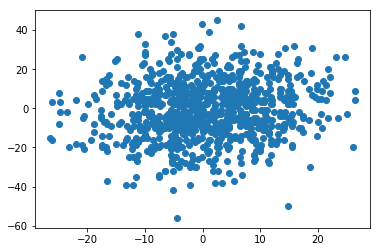

In [200]:
plt.figure(1)
plt.scatter(games['netScore'],games['PLUS_MINUS'])